In [1]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
import time
import cv2
import copy
import utils
from utils import computeRMSE, computeASSD, computeHD
import projection_utils as proj
import skimage
import enum
import h5py
from emopt5views_matlab import EMOpt5Views, PHOTO

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
SSM_DIR = r"./data/cpdAlignedData/eigValVec/"
CPD_ALIGNED_DIR = r"./data/cpdAlignedData/"
NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
PHOTO_PATH = r"./dataWithPhoto/normal_resized/"
EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/"
RGB_EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/RGB/"
NUM_PC = 10
PG_NPY = os.path.join("res-2D-3D", "Y_pg.npy")
MASK_NPY = os.path.join("res-2D-3D", "X_mask.npy")
PARAM_DIR = r"./data/params/"
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48
MATLAB_PATH = r"./matlab_script"
STAGE0_MAT_DIR = os.path.join(MATLAB_PATH, "stage0-mat")

name_idx_df = pd.read_csv(NAME_IDX_MAP_CSV)
# 顺序相互对应
photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]

In [3]:
TagID = 0
photos = proj.getPhotos(PHOTO_PATH, name_idx_df, TagID, photo_types, resized_width=1440)

['./dataWithPhoto/normal_resized/刘晓泉_192971_上牙列.png', './dataWithPhoto/normal_resized/刘晓泉_192971_下牙列.png', './dataWithPhoto/normal_resized/刘晓泉_192971_左侧咬合.png', './dataWithPhoto/normal_resized/刘晓泉_192971_右侧咬合.png', './dataWithPhoto/normal_resized/刘晓泉_192971_正位像.png']


In [ ]:
proj.visualizeEdgeMasks(photos, photo_types)

In [ ]:
gaussianFilteredImages = [skimage.filters.gaussian(photo,sigma=3,channel_axis=2) for photo in photos]
proj.visualizeEdgeMasks(gaussianFilteredImages, photo_types)

In [ ]:
cannyEdges = [skimage.feature.canny(skimage.color.rgb2gray(photo), sigma=2) for photo in photos]
proj.visualizeEdgeMasks(cannyEdges, photo_types)

In [ ]:
butterWorthImages = [0.5+0.5*skimage.filters.butterworth(image, cutoff_frequency_ratio=0.005, high_pass=True, order=2.0, channel_axis=-1) for image in photos]
proj.visualizeEdgeMasks(butterWorthImages, photo_types)

In [ ]:
farid_v_edges = [skimage.filters.farid_v(skimage.color.rgb2gray(photo), mask=None) for photo in photos]
proj.visualizeEdgeMasks(farid_v_edges, photo_types)

In [ ]:
sobel_edges = [skimage.filters.sobel(skimage.color.rgb2gray(photo), mask=None) for photo in photos]
for sobel_edge in sobel_edges:
    sobel_edge[sobel_edge>0.01] = 1.
    sobel_edge[sobel_edge<0.01] = 0.
proj.visualizeEdgeMasks(sobel_edges, photo_types)

num of contour points in upperPhoto: 1553872 
num of contour points in lowerPhoto: 1548154 
num of contour points in leftPhoto: 1551040 
num of contour points in rightPhoto: 1548899 
num of contour points in frontalPhoto: 1538996 


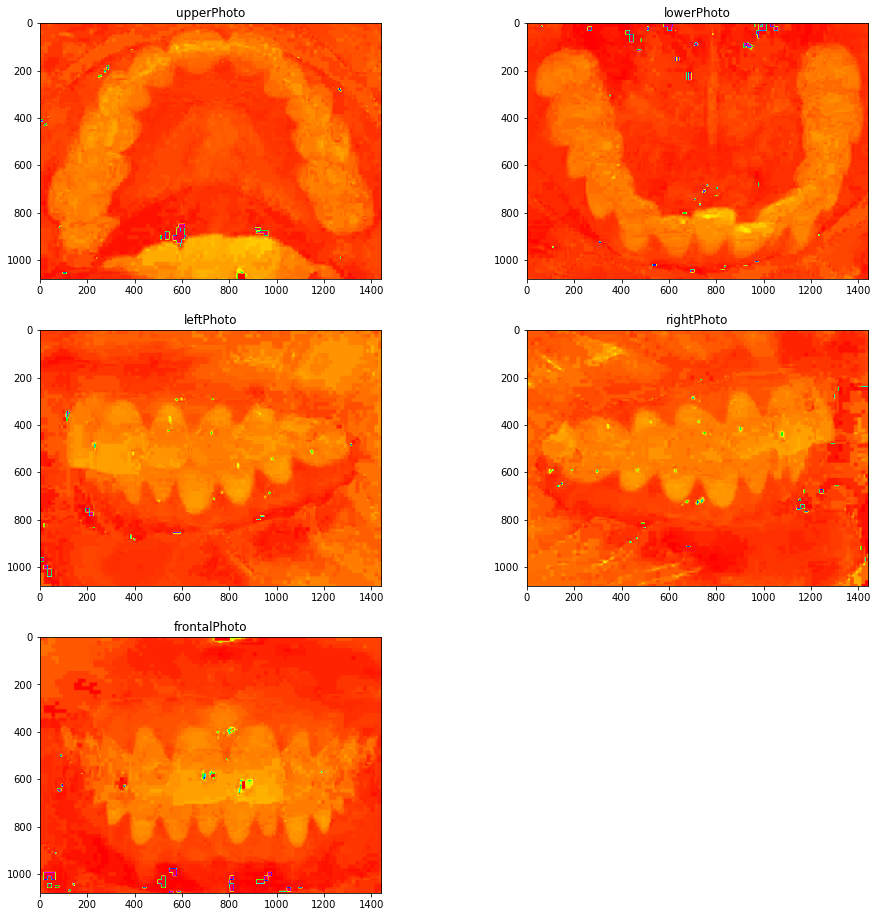

In [35]:
hsv_photos = [skimage.color.rgb2hsv(photo) for photo in photos]
hue_imgs = [img[:,:,0] for img in hsv_photos]
# for hue_img in hue_imgs:
#     hue_img[hue_img>0.05] = 1.0
proj.visualizeEdgeMasks(hue_imgs, photo_types, "hsv")

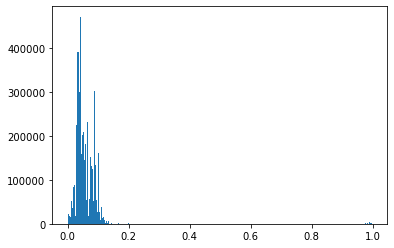

In [27]:
plt.hist(np.array(hue_imgs).ravel(), 512)
plt.show()

num of contour points in upperPhoto: 391981 
num of contour points in lowerPhoto: 286242 
num of contour points in leftPhoto: 468070 
num of contour points in rightPhoto: 375074 
num of contour points in frontalPhoto: 349690 


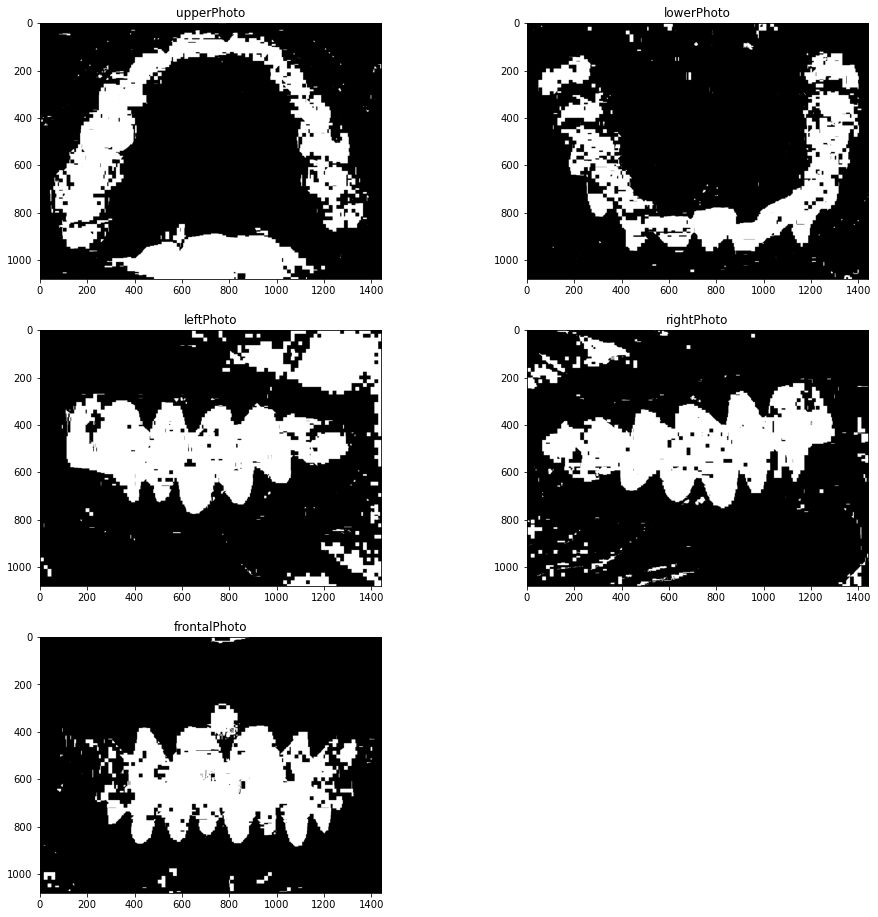

In [ ]:
hue_threshold = 0.075
binary_imgs = [hue_img>hue_threshold for hue_img in hue_imgs]
proj.visualizeEdgeMasks(binary_imgs, photo_types, "gray")